# Gromore basic domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [13]:
#import packages
import flopy
import numpy as np
import matplotlib as mp
import os
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv
from numpy import asarray
from numpy import savetxt

#print full output
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

#Delete Packages
# dir = "/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/GroMore_Project/amanda/scenario2"
# dir = "C:\Users\vivek\Documents\UA Coursework\HWRS 582 Groundwater Modelling\GroMore_Project\Vivek\Scenario 1"
# dir = "/Users/hardknox47/Desktop/HWRS482/hw482/GroMore_Project/Justin"

# files = os.listdir(dir)
# ext=['.dis','.bas','.lpf','.oc','.pcg','.wel','.hds','.cbc','.riv','.list','.nam','.evt',
#      '.rch','.mpbas','.mpend','.mplst','.mpnam','.mppth','.mpsim','.log','.timeseries',
#      '.lis','.chd','.ddn','.sloc']
# for file in files:
#     for i in range(0,len(ext)):
#         if file.endswith(ext[i]):
#             os.remove(os.path.join(dir,file))

# Scenario 5: Post agriculture model with seasonality - future projection
Add the proposed agricultural element (pumping and localized recharge) for growing pistachios to your post-development model with seasonality. Agriculture starts now, 100 years after the end of the burn-in. Both pumping and recharge related to agriculture occur at the rates described and are continuous throughout the year.

## 2. Discretization and other inputs

In [14]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Subsurface properties
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 49.0)
ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), 
        int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 

rip_ET= 5e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
rip_rows_forced = (21.0, 28.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)
rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), 
        int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 

extinction_depth = 10 #m

## Recharge
rech=4e-5  #m/d
rechag=0.00015*0.125  # (0.0001, 0.00015, 0.0002) m/day (wheat, pistachios, cotton)

rechxy=[(0,0),(0,36000)]  #recharge zone

rechag_rows=(28,29)
rechag_cols=(18,19)

rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 15.0)

rech_zone = np.zeros((1,nrow,ncol))
rech_zone[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),
          int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
rech_zone[0,int(rechag_rows[0]):int(rechag_rows[1]),
          int(rechag_cols[0]):int(rechag_cols[1])]=rechag
#print("recharge location forced(col, row)", rech_cols_forced,rech_rows_forced)

# Setting up wells
pumping1 = 0 # m3/day      -1500 pumping rate for water supply well  
pumping2 = -4500*0.125 # m^3/d   (-3000,-4500,-6000) irrigation well pumping rate (wheat, pistachios, cotton)

well_agua = [2,29,37, pumping1] #Well loc (layer, row, column)
well_ag = [0,38,12, pumping2] #Well loc (layer, row, column)
MW1 = [0,25,24,0]
MW2 = [0,37,12,0]

wel_spd = {0: [well_agua, well_ag, MW1, MW2]}

## init boundary conditions
h_right = 70

In [15]:
# savetxt('rech_zone.csv', rech_zone[0], delimiter=',')

### Layering

In [16]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 

## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 

## Boundary Conditions

In [17]:
#setup initial heads as the end of scenario 2 burn in values (after 200 years w. seasonality)

H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[0, :, :] = np.genfromtxt('top_head_postdevel_100yr.csv', delimiter=',', dtype=float)  #initialize the top layer with 200 yr burn in vals
H_init[1, :, :] = np.genfromtxt('mid_head_postdevel_100yr.csv', delimiter=',', dtype=float)  #initialize the mid layer with 200 yr burn in vals
H_init[2, :, :] = np.genfromtxt('bot_head_postdevel_100yr.csv', delimiter=',', dtype=float)  #initialize the bottom layer with 200 yr burn in vals

#Adding no flow boundaries
#########################

# Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  # 1st col = no flow       
ibound[:,:,49] = -1  # last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

## River Properties

In [18]:
#DEFINE RIVERS
riv_row= 24
riv_sp = [] #create list to store all river cells for stress period 1
k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(1)*(1000)/(sed_thick) #river bed conductance in m^2/d
r_stage = .5 #stage in river (stress period 1)
r_bott = ztop[riv_row,:] #river bottom
#print(r_bott)
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
#create dictionary of stress period data
riv_spd = {0: riv_sp}

### Setting up seasonality


In [19]:
#We start in October, because that's a water year
sp_peryr = 2        # periods for seasonality (two stress periods per year)
sp1_len = 180       # Length of stress period 1 in days, October-March, no ET
sp2_len = 180      # Length of stress period 2 in days. April - September, regular ET
sim_years = 100       #number of years for transient simulation 
#nper = int(sp_peryr*sim_years + 1) # 201
nper = int(sp_peryr*sim_years)

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False # transient flag is false
#steady[0] = True    # initial stress period is steady-state or true

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)#100 repeating sets of the two stress periods
#perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen*1  
#nstp[0]=1 #for the steady state solution we just want one output

### Setting up seasonal ET

In [20]:
#Setup alternating ET values
#ET_zone has the seasonal ET values
                      
ET_dict = {} #set up an ET dictionary, where each key is a stress period num 0-50
ET_zone2 = ET_zone * 0 
for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
    if p == 0:
        ET_dict[p] = ET_zone
    elif int(p % 2) != 0:
        ET_dict[p]=ET_zone2
        #print(p)
    else: 
        ET_dict[p] = ET_zone

## Setting up the post development pumping

In [21]:
#addings these pumping wells for aguaseca community well
t=np.arange(0,210,10)
# print(t)
pumping_spd={}
for a in range(0,len(t)):
    pumping_spd[a]=[2,29,37,-(1.5*(t[a])**(1.5))]
# print(pumping_spd)

#Set up the wel data for stress periods, changing well_agua pumping rate
wel_spd = {}  

i=11

for p in range(0,201): #nper = 201
    if (199>p>0 and ((p) % 20) == 0):
        i=i+1
    if (p >= 0 and p <= 21):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p > 21 and p <= 41):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p > 41 and p <= 61):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p > 61 and p <= 81):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p > 81 and p <= 101):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p > 101 and p <= 121):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p > 121 and p <= 141):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p > 141 and p <= 161):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p > 161 and p <= 181):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p > 181 and p <= 201):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    else:
        print('p not in range')

{0: [2, 29, 37, -0.0], 1: [2, 29, 37, -47.43416490252569], 2: [2, 29, 37, -134.1640786499874], 3: [2, 29, 37, -246.47515087732475], 4: [2, 29, 37, -379.4733192202055], 5: [2, 29, 37, -530.3300858899106], 6: [2, 29, 37, -697.137002317335], 7: [2, 29, 37, -878.4930278607792], 8: [2, 29, 37, -1073.3126291998992], 9: [2, 29, 37, -1280.7224523681937], 10: [2, 29, 37, -1500.0], 11: [2, 29, 37, -1730.53459948075], 12: [2, 29, 37, -1971.801207018598], 13: [2, 29, 37, -2223.342078943319], 14: [2, 29, 37, -2484.753508901839], 15: [2, 29, 37, -2755.675960631075], 16: [2, 29, 37, -3035.786553761644], 17: [2, 29, 37, -3324.7932266533508], 18: [2, 29, 37, -3622.4301235496596], 19: [2, 29, 37, -3928.453894345713], 20: [2, 29, 37, -4242.640687119285]}


## Set up and run scenario 3

In [23]:
#Initialize the model
modelname = "Scenario_5"
moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"
# moddir="/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp = nstp)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)

#create rch object
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     


# Attach ET package
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_dict, exdp=extinction_depth, ipakcb=53) 

wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

#Setting up RIV package
riv = flopy.modflow.ModflowRiv(model=m,stress_period_data = riv_spd, ipakcb=53)

#Output control - OC 
oc_spd = {}
for kper in range(1,nper): #nper is 201, this is the key for each entry in oc_spd dict
    oc_spd[(kper, 1)] = ['save head','save drawdown','save budget','print head','print budget']
    oc_spd[(kper, 90)] = ['save head','save drawdown','save budget','print head','print budget']
    oc_spd[(kper, 179)] = ['save head','save drawdown','save budget','print head','print budget']
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

#Numerical solver - pcg
# pcg = flopy.modflow.ModflowPcg(model=m)
#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=100, iter1=200, relax = 0.97, damp = 0.9)

#write the inputs
m.write_input()   

m.evt.check()
m.oc.check()
m.oc.check()
m.lpf.check()
m.pcg.check()
m.riv.check()
m.rch.check()
m.dis.check()

check method not implemented for EVT Package.

OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


LPF PACKAGE DATA VALIDATION:
  1 Warning:
    STORAGECOEFFICIENT option is activated, storage values are read storage coefficients

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    zero or negative vertical hydraulic conductivity values
    negative horizontal anisotropy values
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivity values above checker threshold of 100000.0
    zero or negative specific storage values
    specific storage values below checker threshold of 1e-06
    specific storage values above checker threshold of 0.01
    zero or negative 

In [24]:
#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Scenario_5.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/27 10:20:27

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress 

 Solving:  Stress period:     1    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   122    Ground-Wa

 Solving:  Stress period:     2    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    60    Ground-Wa

 Solving:  Stress period:     2    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   166    Ground-Wa

 Solving:  Stress period:     3    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   100    Ground-Wa

 Solving:  Stress period:     4    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    36    Ground-Wa

 Solving:  Stress period:     4    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   155    Ground-Wa

 Solving:  Stress period:     5    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    94    Ground-Wa

 Solving:  Stress period:     6    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    24    Ground-Wa

 Solving:  Stress period:     6    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   144    Ground-Wa

 Solving:  Stress period:     7    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    71    Ground-Wa

 Solving:  Stress period:     7    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     5    Ground-Wa

 Solving:  Stress period:     8    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   118    Ground-Wa

 Solving:  Stress period:     9    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    45    Ground-Wa

 Solving:  Stress period:     9    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   152    Ground-Wa

 Solving:  Stress period:    10    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    86    Ground-Wa

 Solving:  Stress period:    11    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    15    Ground-Wa

 Solving:  Stress period:    11    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   129    Ground-Wa

 Solving:  Stress period:    12    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    56    Ground-Wa

 Solving:  Stress period:    12    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   165    Ground-Wa

 Solving:  Stress period:    13    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    93    Ground-Wa

 Solving:  Stress period:    14    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    23    Ground-Wa

 Solving:  Stress period:    14    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   143    Ground-Wa

 Solving:  Stress period:    15    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    70    Ground-Wa

 Solving:  Stress period:    15    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     9    Ground-Wa

 Solving:  Stress period:    16    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   124    Ground-Wa

 Solving:  Stress period:    17    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    52    Ground-Wa

 Solving:  Stress period:    17    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   163    Ground-Wa

 Solving:  Stress period:    18    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   101    Ground-Wa

 Solving:  Stress period:    19    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    31    Ground-Wa

 Solving:  Stress period:    19    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   137    Ground-Wa

 Solving:  Stress period:    20    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    64    Ground-Wa

 Solving:  Stress period:    20    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   178    Ground-Wa

 Solving:  Stress period:    21    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   117    Ground-Wa

 Solving:  Stress period:    22    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    56    Ground-Wa

 Solving:  Stress period:    22    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:   169    Ground-Wa

 Solving:  Stress period:    23    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   104    Ground-Wa

 Solving:  Stress period:    24    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    33    Ground-Wa

 Solving:  Stress period:    24    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   140    Ground-Wa

 Solving:  Stress period:    25    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    66    Ground-Wa

 Solving:  Stress period:    25    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     3    Ground-Wa

 Solving:  Stress period:    26    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   116    Ground-Wa

 Solving:  Stress period:    27    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    55    Ground-Wa

 Solving:  Stress period:    27    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   167    Ground-Wa

 Solving:  Stress period:    28    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   105    Ground-Wa

 Solving:  Stress period:    29    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    36    Ground-Wa

 Solving:  Stress period:    29    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   146    Ground-Wa

 Solving:  Stress period:    30    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    79    Ground-Wa

 Solving:  Stress period:    30    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     5    Ground-Wa

 Solving:  Stress period:    31    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   122    Ground-Wa

 Solving:  Stress period:    32    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    49    Ground-Wa

 Solving:  Stress period:    32    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   162    Ground-Wa

 Solving:  Stress period:    33    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    90    Ground-Wa

 Solving:  Stress period:    34    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    26    Ground-Wa

 Solving:  Stress period:    34    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   135    Ground-Wa

 Solving:  Stress period:    35    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    70    Ground-Wa

 Solving:  Stress period:    35    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   180    Ground-Wa

 Solving:  Stress period:    36    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   108    Ground-Wa

 Solving:  Stress period:    37    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    34    Ground-Wa

 Solving:  Stress period:    37    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   142    Ground-Wa

 Solving:  Stress period:    38    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    82    Ground-Wa

 Solving:  Stress period:    39    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    16    Ground-Wa

 Solving:  Stress period:    39    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   137    Ground-Wa

 Solving:  Stress period:    40    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    74    Ground-Wa

 Solving:  Stress period:    40    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:     9    Ground-Wa

 Solving:  Stress period:    41    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   128    Ground-Wa

 Solving:  Stress period:    42    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    60    Ground-Wa

 Solving:  Stress period:    42    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   169    Ground-Wa

 Solving:  Stress period:    43    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   102    Ground-Wa

 Solving:  Stress period:    44    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    28    Ground-Wa

 Solving:  Stress period:    44    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   146    Ground-Wa

 Solving:  Stress period:    45    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    86    Ground-Wa

 Solving:  Stress period:    46    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    20    Ground-Wa

 Solving:  Stress period:    46    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   139    Ground-Wa

 Solving:  Stress period:    47    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    67    Ground-Wa

 Solving:  Stress period:    47    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     1    Ground-Wa

 Solving:  Stress period:    48    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   117    Ground-Wa

 Solving:  Stress period:    49    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    47    Ground-Wa

 Solving:  Stress period:    49    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   159    Ground-Wa

 Solving:  Stress period:    50    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    96    Ground-Wa

 Solving:  Stress period:    51    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    24    Ground-Wa

 Solving:  Stress period:    51    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   137    Ground-Wa

 Solving:  Stress period:    52    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    72    Ground-Wa

 Solving:  Stress period:    53    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    13    Ground-Wa

 Solving:  Stress period:    53    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   125    Ground-Wa

 Solving:  Stress period:    54    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    62    Ground-Wa

 Solving:  Stress period:    54    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     2    Ground-Wa

 Solving:  Stress period:    55    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   110    Ground-Wa

 Solving:  Stress period:    56    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    38    Ground-Wa

 Solving:  Stress period:    56    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   160    Ground-Wa

 Solving:  Stress period:    57    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   100    Ground-Wa

 Solving:  Stress period:    58    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    30    Ground-Wa

 Solving:  Stress period:    58    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   149    Ground-Wa

 Solving:  Stress period:    59    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    88    Ground-Wa

 Solving:  Stress period:    60    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    15    Ground-Wa

 Solving:  Stress period:    60    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   124    Ground-Wa

 Solving:  Stress period:    61    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    50    Ground-Wa

 Solving:  Stress period:    61    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   162    Ground-Wa

 Solving:  Stress period:    62    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    99    Ground-Wa

 Solving:  Stress period:    63    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    32    Ground-Wa

 Solving:  Stress period:    63    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   143    Ground-Wa

 Solving:  Stress period:    64    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    70    Ground-Wa

 Solving:  Stress period:    64    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     5    Ground-Wa

 Solving:  Stress period:    65    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   115    Ground-Wa

 Solving:  Stress period:    66    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    43    Ground-Wa

 Solving:  Stress period:    66    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   154    Ground-Wa

 Solving:  Stress period:    67    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    85    Ground-Wa

 Solving:  Stress period:    67    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    11    Ground-Wa

 Solving:  Stress period:    68    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   128    Ground-Wa

 Solving:  Stress period:    69    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    64    Ground-Wa

 Solving:  Stress period:    69    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   178    Ground-Wa

 Solving:  Stress period:    70    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   108    Ground-Wa

 Solving:  Stress period:    71    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    39    Ground-Wa

 Solving:  Stress period:    71    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   152    Ground-Wa

 Solving:  Stress period:    72    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    83    Ground-Wa

 Solving:  Stress period:    73    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    16    Ground-Wa

 Solving:  Stress period:    73    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   132    Ground-Wa

 Solving:  Stress period:    74    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    68    Ground-Wa

 Solving:  Stress period:    74    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   178    Ground-Wa

 Solving:  Stress period:    75    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   108    Ground-Wa

 Solving:  Stress period:    76    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    42    Ground-Wa

 Solving:  Stress period:    76    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   161    Ground-Wa

 Solving:  Stress period:    77    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    99    Ground-Wa

 Solving:  Stress period:    78    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    26    Ground-Wa

 Solving:  Stress period:    78    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   144    Ground-Wa

 Solving:  Stress period:    79    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    71    Ground-Wa

 Solving:  Stress period:    79    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     4    Ground-Wa

 Solving:  Stress period:    80    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   112    Ground-Wa

 Solving:  Stress period:    81    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    51    Ground-Wa

 Solving:  Stress period:    81    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   162    Ground-Wa

 Solving:  Stress period:    82    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    96    Ground-Wa

 Solving:  Stress period:    83    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    22    Ground-Wa

 Solving:  Stress period:    83    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   141    Ground-Wa

 Solving:  Stress period:    84    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    72    Ground-Wa

 Solving:  Stress period:    84    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   178    Ground-Wa

 Solving:  Stress period:    85    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   112    Ground-Wa

 Solving:  Stress period:    86    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    38    Ground-Wa

 Solving:  Stress period:    86    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   155    Ground-Wa

 Solving:  Stress period:    87    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    87    Ground-Wa

 Solving:  Stress period:    88    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    17    Ground-Wa

 Solving:  Stress period:    88    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   132    Ground-Wa

 Solving:  Stress period:    89    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    58    Ground-Wa

 Solving:  Stress period:    89    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   172    Ground-Wa

 Solving:  Stress period:    90    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   107    Ground-Wa

 Solving:  Stress period:    91    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    34    Ground-Wa

 Solving:  Stress period:    91    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   156    Ground-Wa

 Solving:  Stress period:    92    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    93    Ground-Wa

 Solving:  Stress period:    93    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    20    Ground-Wa

 Solving:  Stress period:    93    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   138    Ground-Wa

 Solving:  Stress period:    94    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    75    Ground-Wa

 Solving:  Stress period:    94    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:     4    Ground-Wa

 Solving:  Stress period:    95    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   124    Ground-Wa

 Solving:  Stress period:    96    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    53    Ground-Wa

 Solving:  Stress period:    96    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   161    Ground-Wa

 Solving:  Stress period:    97    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    99    Ground-Wa

 Solving:  Stress period:    98    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    28    Ground-Wa

 Solving:  Stress period:    98    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   146    Ground-Wa

 Solving:  Stress period:    99    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    86    Ground-Wa

 Solving:  Stress period:   100    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    19    Ground-Wa

 Solving:  Stress period:   100    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   132    Ground-Wa

 Solving:  Stress period:   101    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    61    Ground-Wa

 Solving:  Stress period:   101    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   175    Ground-Wa

 Solving:  Stress period:   102    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   109    Ground-Wa

 Solving:  Stress period:   103    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    36    Ground-Wa

 Solving:  Stress period:   103    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   142    Ground-Wa

 Solving:  Stress period:   104    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    69    Ground-Wa

 Solving:  Stress period:   104    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   178    Ground-Wa

 Solving:  Stress period:   105    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:   116    Ground-Wa

 Solving:  Stress period:   106    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    45    Ground-Wa

 Solving:  Stress period:   106    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   167    Ground-Wa

 Solving:  Stress period:   107    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   102    Ground-Wa

 Solving:  Stress period:   108    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    29    Ground-Wa

 Solving:  Stress period:   108    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   148    Ground-Wa

 Solving:  Stress period:   109    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    87    Ground-Wa

 Solving:  Stress period:   110    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    18    Ground-Wa

 Solving:  Stress period:   110    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   132    Ground-Wa

 Solving:  Stress period:   111    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    65    Ground-Wa

 Solving:  Stress period:   111    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     5    Ground-Wa

 Solving:  Stress period:   112    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   122    Ground-Wa

 Solving:  Stress period:   113    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    55    Ground-Wa

 Solving:  Stress period:   113    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   177    Ground-Wa

 Solving:  Stress period:   114    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   110    Ground-Wa

 Solving:  Stress period:   115    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    47    Ground-Wa

 Solving:  Stress period:   115    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   155    Ground-Wa

 Solving:  Stress period:   116    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    87    Ground-Wa

 Solving:  Stress period:   117    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    17    Ground-Wa

 Solving:  Stress period:   117    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   131    Ground-Wa

 Solving:  Stress period:   118    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    70    Ground-Wa

 Solving:  Stress period:   118    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   178    Ground-Wa

 Solving:  Stress period:   119    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   110    Ground-Wa

 Solving:  Stress period:   120    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    47    Ground-Wa

 Solving:  Stress period:   120    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   166    Ground-Wa

 Solving:  Stress period:   121    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   102    Ground-Wa

 Solving:  Stress period:   122    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    28    Ground-Wa

 Solving:  Stress period:   122    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   143    Ground-Wa

 Solving:  Stress period:   123    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    74    Ground-Wa

 Solving:  Stress period:   123    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     6    Ground-Wa

 Solving:  Stress period:   124    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:   116    Ground-Wa

 Solving:  Stress period:   125    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    54    Ground-Wa

 Solving:  Stress period:   125    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   170    Ground-Wa

 Solving:  Stress period:   126    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   106    Ground-Wa

 Solving:  Stress period:   127    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    33    Ground-Wa

 Solving:  Stress period:   127    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   142    Ground-Wa

 Solving:  Stress period:   128    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    79    Ground-Wa

 Solving:  Stress period:   129    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    13    Ground-Wa

 Solving:  Stress period:   129    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   129    Ground-Wa

 Solving:  Stress period:   130    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    67    Ground-Wa

 Solving:  Stress period:   130    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:     5    Ground-Wa

 Solving:  Stress period:   131    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   117    Ground-Wa

 Solving:  Stress period:   132    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    44    Ground-Wa

 Solving:  Stress period:   132    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   151    Ground-Wa

 Solving:  Stress period:   133    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    90    Ground-Wa

 Solving:  Stress period:   134    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    21    Ground-Wa

 Solving:  Stress period:   134    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   136    Ground-Wa

 Solving:  Stress period:   135    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    74    Ground-Wa

 Solving:  Stress period:   135    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     7    Ground-Wa

 Solving:  Stress period:   136    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   120    Ground-Wa

 Solving:  Stress period:   137    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    47    Ground-Wa

 Solving:  Stress period:   137    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   157    Ground-Wa

 Solving:  Stress period:   138    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    94    Ground-Wa

 Solving:  Stress period:   139    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    23    Ground-Wa

 Solving:  Stress period:   139    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   130    Ground-Wa

 Solving:  Stress period:   140    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    59    Ground-Wa

 Solving:  Stress period:   140    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   169    Ground-Wa

 Solving:  Stress period:   141    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   108    Ground-Wa

 Solving:  Stress period:   142    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    36    Ground-Wa

 Solving:  Stress period:   142    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   155    Ground-Wa

 Solving:  Stress period:   143    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    95    Ground-Wa

 Solving:  Stress period:   144    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    25    Ground-Wa

 Solving:  Stress period:   144    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   139    Ground-Wa

 Solving:  Stress period:   145    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    79    Ground-Wa

 Solving:  Stress period:   145    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    12    Ground-Wa

 Solving:  Stress period:   146    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   123    Ground-Wa

 Solving:  Stress period:   147    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    50    Ground-Wa

 Solving:  Stress period:   147    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   161    Ground-Wa

 Solving:  Stress period:   148    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    96    Ground-Wa

 Solving:  Stress period:   149    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    26    Ground-Wa

 Solving:  Stress period:   149    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   132    Ground-Wa

 Solving:  Stress period:   150    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    71    Ground-Wa

 Solving:  Stress period:   150    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   180    Ground-Wa

 Solving:  Stress period:   151    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   117    Ground-Wa

 Solving:  Stress period:   152    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    43    Ground-Wa

 Solving:  Stress period:   152    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   159    Ground-Wa

 Solving:  Stress period:   153    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    99    Ground-Wa

 Solving:  Stress period:   154    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    29    Ground-Wa

 Solving:  Stress period:   154    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   145    Ground-Wa

 Solving:  Stress period:   155    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    84    Ground-Wa

 Solving:  Stress period:   156    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    18    Ground-Wa

 Solving:  Stress period:   156    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   133    Ground-Wa

 Solving:  Stress period:   157    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    60    Ground-Wa

 Solving:  Stress period:   157    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   171    Ground-Wa

 Solving:  Stress period:   158    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   104    Ground-Wa

 Solving:  Stress period:   159    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    31    Ground-Wa

 Solving:  Stress period:   159    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   137    Ground-Wa

 Solving:  Stress period:   160    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    71    Ground-Wa

 Solving:  Stress period:   160    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     2    Ground-Wa

 Solving:  Stress period:   161    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   118    Ground-Wa

 Solving:  Stress period:   162    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    46    Ground-Wa

 Solving:  Stress period:   162    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   166    Ground-Wa

 Solving:  Stress period:   163    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:   101    Ground-Wa

 Solving:  Stress period:   164    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    27    Ground-Wa

 Solving:  Stress period:   164    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   137    Ground-Wa

 Solving:  Stress period:   165    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    68    Ground-Wa

 Solving:  Stress period:   165    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   179    Ground-Wa

 Solving:  Stress period:   166    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   114    Ground-Wa

 Solving:  Stress period:   167    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    40    Ground-Wa

 Solving:  Stress period:   167    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   162    Ground-Wa

 Solving:  Stress period:   168    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    92    Ground-Wa

 Solving:  Stress period:   169    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    18    Ground-Wa

 Solving:  Stress period:   169    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   131    Ground-Wa

 Solving:  Stress period:   170    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    67    Ground-Wa

 Solving:  Stress period:   170    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   174    Ground-Wa

 Solving:  Stress period:   171    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   107    Ground-Wa

 Solving:  Stress period:   172    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    33    Ground-Wa

 Solving:  Stress period:   172    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   147    Ground-Wa

 Solving:  Stress period:   173    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    85    Ground-Wa

 Solving:  Stress period:   174    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    16    Ground-Wa

 Solving:  Stress period:   174    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   127    Ground-Wa

 Solving:  Stress period:   175    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    64    Ground-Wa

 Solving:  Stress period:   175    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   174    Ground-Wa

 Solving:  Stress period:   176    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   103    Ground-Wa

 Solving:  Stress period:   177    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    31    Ground-Wa

 Solving:  Stress period:   177    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   137    Ground-Wa

 Solving:  Stress period:   178    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    74    Ground-Wa

 Solving:  Stress period:   178    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:     3    Ground-Wa

 Solving:  Stress period:   179    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   118    Ground-Wa

 Solving:  Stress period:   180    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    47    Ground-Wa

 Solving:  Stress period:   180    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   167    Ground-Wa

 Solving:  Stress period:   181    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   104    Ground-Wa

 Solving:  Stress period:   182    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    34    Ground-Wa

 Solving:  Stress period:   182    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   154    Ground-Wa

 Solving:  Stress period:   183    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    95    Ground-Wa

 Solving:  Stress period:   184    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    26    Ground-Wa

 Solving:  Stress period:   184    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   144    Ground-Wa

 Solving:  Stress period:   185    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    71    Ground-Wa

 Solving:  Stress period:   185    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     5    Ground-Wa

 Solving:  Stress period:   186    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   114    Ground-Wa

 Solving:  Stress period:   187    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    54    Ground-Wa

 Solving:  Stress period:   187    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   163    Ground-Wa

 Solving:  Stress period:   188    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    93    Ground-Wa

 Solving:  Stress period:   189    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    20    Ground-Wa

 Solving:  Stress period:   189    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   140    Ground-Wa

 Solving:  Stress period:   190    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    77    Ground-Wa

 Solving:  Stress period:   190    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:     6    Ground-Wa

 Solving:  Stress period:   191    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   121    Ground-Wa

 Solving:  Stress period:   192    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    47    Ground-Wa

 Solving:  Stress period:   192    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   165    Ground-Wa

 Solving:  Stress period:   193    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   103    Ground-Wa

 Solving:  Stress period:   194    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    32    Ground-Wa

 Solving:  Stress period:   194    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   145    Ground-Wa

 Solving:  Stress period:   195    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    83    Ground-Wa

 Solving:  Stress period:   196    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    14    Ground-Wa

 Solving:  Stress period:   196    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   124    Ground-Wa

 Solving:  Stress period:   197    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    60    Ground-Wa

 Solving:  Stress period:   197    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   171    Ground-Wa

 Solving:  Stress period:   198    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   107    Ground-Wa

 Solving:  Stress period:   199    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    34    Ground-Wa

 Solving:  Stress period:   199    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   140    Ground-Wa

 Solving:  Stress period:   200    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    77    Ground-Wa

 Solving:  Stress period:   200    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   180    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/04/27 10:28:54
 Elapsed run time:  8 Minutes, 27.102 Seconds

  Normal termination of simulation


## Read in the outputs

In [25]:
modelname = "Scenario_5"
hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times()                               # returns a list of timesteps

#extract binary data from head file
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

#get data from python objects
for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data() #append heads to head list for ea stress per
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) #append right face flow to frf list for ea stress per
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per

## Plot head at monitoring wells

In [26]:
#get time series for a certain cell

cell_id1 = (0,25,24) #cell ID of MW1
cell_id2 = (0,37,12) #cell ID of MW2
ag_id = (0,38,12)#cell ID of ag well
agua_id = (2,29,37) #Cell ID of aguaseca community well

time_series1 = headobj.get_ts(cell_id1) #get the time series at MW1
time_series2 = headobj.get_ts(cell_id2) #get the time series at MW2
time_series_ag = headobj.get_ts(ag_id) #get the time series at ag well
time_series_agua = headobj.get_ts(agua_id) #get the time series at agua seca com well
print(time_series_ag)

[[  182.          90.554146]
 [  271.          90.53342 ]
 [  360.          90.519264]
 [  362.          90.51899 ]
 [  451.          90.50828 ]
 [  540.          90.499535]
 [  542.          90.499374]
 [  631.          90.49219 ]
 [  720.          90.486176]
 [  722.          90.48605 ]
 [  811.          90.48062 ]
 [  900.          90.47569 ]
 [  902.          90.47558 ]
 [  991.          90.47142 ]
 [ 1080.          90.46772 ]
 [ 1082.          90.467636]
 [ 1171.          90.46409 ]
 [ 1260.          90.460915]
 [ 1262.          90.46085 ]
 [ 1351.          90.45799 ]
 [ 1440.          90.45509 ]
 [ 1442.          90.45503 ]
 [ 1531.          90.45223 ]
 [ 1620.          90.44965 ]
 [ 1622.          90.44959 ]
 [ 1711.          90.4472  ]
 [ 1800.          90.445076]
 [ 1802.          90.44504 ]
 [ 1891.          90.44318 ]
 [ 1980.          90.44134 ]
 [ 1982.          90.4413  ]
 [ 2071.          90.43952 ]
 [ 2160.          90.43772 ]
 [ 2162.          90.43768 ]
 [ 2251.      

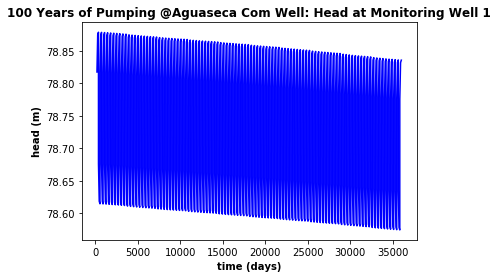

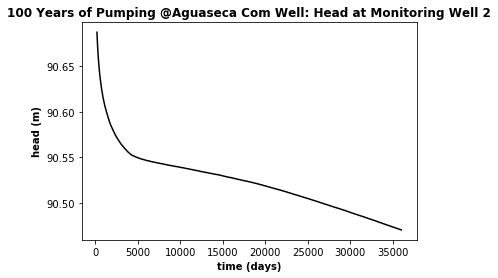

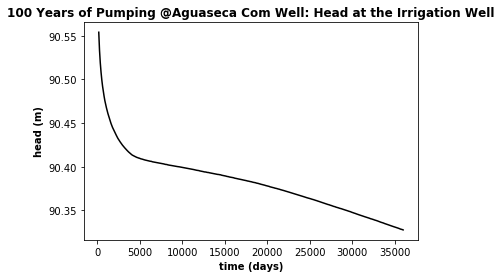

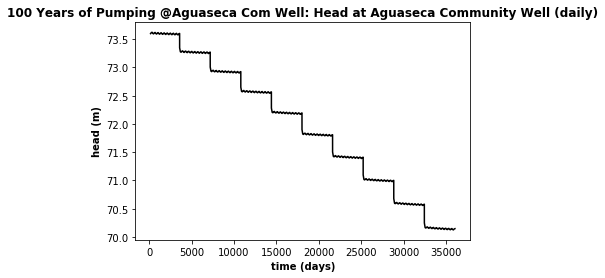

In [27]:
#create plot of MW1
plt.subplot(1, 1, 1)
ax=plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title("100 Years of Pumping @Aguaseca Com Well: Head at Monitoring Well 1",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record
plt.show()

#create plot of MW2
plt.subplot(1, 1, 1)
ax=plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title("100 Years of Pumping @Aguaseca Com Well: Head at Monitoring Well 2",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series2[:, 0], time_series2[:, 1], 'k-') #plot the time series with points at each record
plt.show()

#create plot of Ag well
plt.subplot(1, 1, 1)
ax=plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title("100 Years of Pumping @Aguaseca Com Well: Head at the Irrigation Well",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series_ag[:, 0], time_series_ag[:, 1], 'k-') #plot the time series with points at each record
plt.show()

#create plot of Aguaseca com well
plt.subplot(1, 1, 1)
ax=plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title("100 Years of Pumping @Aguaseca Com Well: Head at Aguaseca Community Well (daily)",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series_agua[:, 0], time_series_agua[:, 1], 'k-') #plot the time series with points at each record
plt.show()

## Saving final head array to start init heads in scen4

In [28]:
head_top = head['sp%s'%(len(head)-1)][0,:,:]
head_mid = head['sp%s'%(len(head)-1)][1,:,:]
head_bot = head['sp%s'%(len(head)-1)][2,:,:]

savetxt('top_head_postdevel_200yr_w_ag.csv', head_top, delimiter=',')
savetxt('mid_head_postdevel_200yr_w_ag.csv', head_mid, delimiter=',')
savetxt('bot_head_postdevel_200yr_w_ag.csv', head_bot, delimiter=',')

In [29]:
#Getting final heads
print("final Head at Monitoring Well 2 = ", head['sp%s'%(len(head)-1)][0, 37, 12])
print("final Head at Monitoring Well 1 = ", head['sp%s'%(len(head)-1)][0, 25, 24])
print("final Head at Community  Well 1 = ", head['sp%s'%(len(head)-1)][2, 29, 37])

final Head at Monitoring Well 2 =  90.47035
final Head at Monitoring Well 1 =  78.835915
final Head at Community  Well 1 =  70.14662
